# Ex 9: The Martian

In [79]:
import matplotlib.pyplot as plt
from math import pi

from space_base import GravBody, Probe
from numpy import linspace, sqrt, pi, cos, sin, arccos

# Define constants
G = 6.67e-11  # Gravitational constant
mars = GravBody(name="Mars", mass=0.64169e24, radius=3389.5e3)  # Mars as an object with mass and radius
sun = GravBody(name="Sun", mass=1_988_500e24, radius=695_700e3)  # Sun as an object with mass and radius

# Define conversion function
def UA_to_meters(UA):
    return UA * 1.496e11
def meters_to_UA(meters):
    return meters / 1.496e11

The first step is to design a circular orbit at an altitude of 200km. To do this, we can use the previous energy formula and simplify it for a perfectly circular orbit.

$$a=\frac{r_{perihelion}+r_{aphelion}}{2}$$
$$r_{perihelion}=r_{aphelion}=r=a$$
$$V=\sqrt{GM_{sun}(\frac{2}{r}-\frac{1}{a})}$$
$$V=\sqrt{\frac{GM_{sun}}{r}}$$

In [80]:
r = 200e3 + mars.radius  # Radius distance in meters
v_init = sqrt(G * mars.mass / r)  # Velocity on initial circular orbit
v_init / 1e3  # Velocity at perihelion in km/s

3.4530953751079427

We also need to calculate the required velocity the spacecraft must have at its aphelion to return to Earth using a Hohmann transfer. This will be our required residual velocity. 

In [81]:
r_earth = UA_to_meters(1)  # Earth's radius in meters
r_mars = UA_to_meters(1.524)  # Mars' radius in meters

# Define the probe final orbit
r_per = r_earth  # Perihelion distance
r_aph = r_mars  # Aphelion distance

a_tfr = (r_per + r_aph) / 2  # Semi-major axis
v_hyp_abs = sqrt(G * sun.mass * (2 / r_aph - 1 / a_tfr))  # Absolute velocity at aphelion (relative to the Sun)
v_hyp_abs / 1e3  # Residual velocity in km/s

21.47028240604332

This velocity is relative to the Sun. As we are going to simulate the departure from Mars, we need to have the velocity relative to the planet.

In [82]:
v_mars = sqrt(G * sun.mass / r_mars)  # Mars' velocity
v_hyp = v_hyp_abs - v_mars  # Hypothetical velocity at aphelion (relative to Mars)
v_hyp / 1e3  # Velocity in km/s

-2.6491694858055017

To find the periapsis velocity of our spacecraft around Mars so that it can escape, we can use the energy formula. We already know that $E=\frac{1}{2}V^2-\frac{GM_{mars}}{r}$, so if $r\rightarrow\infty;E=\frac{1}{2}V_{hyp}^2$.

So,

$$\frac{1}{2}V_{hyp}^2=\frac{1}{2}V_{per}^2-\frac{GM_{mars}}{r_{per}}$$
$$2*(\frac{1}{2}V_{hyp}^2+\frac{GM_{mars}}{r_{per}})=V_{per}^2$$
$$V_{per}=\sqrt{V_{hyp}^2+\frac{2GM_{mars}}{r_{per}}}$$

In [83]:
v_per = sqrt(v_hyp**2 + 2*G*mars.mass/r)
v_per / 1e3  # Velocity at perihelion in km/s

5.555702863158424

We can also calculate $a$ and $e$ for this escape orbit using:
$$a=\frac{GM_{mars}}{V_{hyp}^2}$$
$$e=\frac{r_p}{a}+1$$

In [84]:
a = G*mars.mass / (v_hyp**2)  # Semi-major axis
a / 1e3  # Semi-major axis in km

6098.620611701382

In [85]:
e = 1 + (r / a)  # Eccentricity
e # Eccentricity

1.5885757171241068

We can also derive the $\beta$ angle with $\cos{\beta}=\frac{1}{e}$.

In [86]:
beta_angle=arccos(1/e)
beta_angle * 180 / pi  # Beta angle in degrees

50.98714749340521

With these settings, we will fire our spacecraft in the opposite direction from Mars' orbit, as we will need to slow down to lower our perihelion to match Earth's orbit.

Finally, we can plot the trajectory until the probe reaches a point PM, which is up to 18 times the Martian radius from the centre of the planet. We can overestimate the time it will take the probe to reach this point by taking the lowest average speed (v_hyp) and using an event condition to trigger the end of the simulation at the right time.

In [87]:
def probeqns(_, posvel):
    r = sqrt(posvel[0] ** 2 + posvel[1] ** 2)
    f = -G * mars.mass / r ** 3
    gravity_force = f * posvel[0:2]
    axy = gravity_force

    return posvel[2], posvel[3], axy[0], axy[1]

In [88]:
xy0 = [-r*cos(beta_angle), r*sin(beta_angle)]  # start position
vxy0 = [sin(beta_angle)*v_per, cos(beta_angle)*v_per]  # start vertical speed
period = 18*mars.radius / abs(v_hyp)

probe = Probe(probeqns, period, period, x0=xy0[0], vx0=vxy0[0], 
            y0=xy0[1], vy0=vxy0[1], event=mars.radius*18, eventflip=True) # probe as an object
t, posvel = probe.odesolve() # solve the differential equations

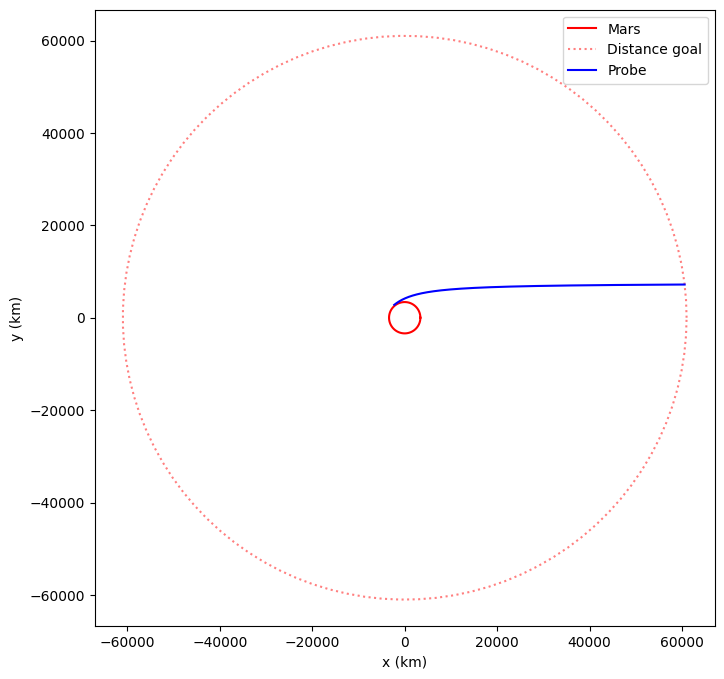

In [89]:
plt.figure(figsize=(8, 8))  # create figure, figsize can be changed as preferred

# Plotting Earth's and Mars' orbit
uang = linspace(0, 2 * pi, 100)
x = (mars.radius / 1e3) * cos(uang)
y = (mars.radius / 1e3) * sin(uang)
plt.plot(x, y, color='red', label='Mars')
# Distance from Mars wanted
x = (mars.radius*18 / 1e3) * cos(uang)
y = (mars.radius*18 / 1e3) * sin(uang)
plt.plot(x, y, color="red", linestyle=":", label='Distance goal', alpha=0.5)

plt.plot(posvel[:, 0] / 1e3, posvel[:, 1] / 1e3, color='blue', label="Probe") # plot the probe's orbit

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.axis('equal')
plt.legend()
plt.show() # make plot appear

As we can imagine, the real time of flight to the point is smaller.

In [90]:
from datetime import timedelta
str(timedelta(seconds=t[len(t)-1])) # time of flight in hh:mm:ss

'5:17:08.021686'

In [91]:
from numpy.lib.stride_tricks import sliding_window_view
pos_slice = sliding_window_view(posvel[:, 0:2], window_shape = [2, 2])
total_dist = sum([ sqrt((pos[0, 0, 0] - pos[0, 1, 0])**2 +  (pos[0, 0, 1] - pos[0, 1, 1])**2) for pos in pos_slice])

In [92]:
sqrt(posvel[len(t)-1, 0]**2 + posvel[len(t)-1, 1]**2)/ 1e3 # Direct distance from Mars center in km

61011.50753647896

As expected, the actual distance travelled is greater than the direct distance between the last point and the centre of Mars.

In [93]:
total_dist / 1e3 # Total distance in km

63492.58205912211

By calculating the actual distance travelled by the spacecraft, we were able to determine its average speed during this journey.

In [94]:
(total_dist / t[len(t)-1]) / 1e3 # average speed in km/s

3.3367936564991236